In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = pd.read_excel('EPOC dataset.xlsx')

columns = ['metal','support','wt.%','ionic species','particle size(nm)','metal loading (mg)','CO2:H2 ratio','temp(℃)','rCO(mol/s)',
          'voltage(V)','ρCO','ΛCO']
data = data[columns]

# change string in data['metal'] into int with metal's atomic mass
data['metal'] = data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                      ['55.8','58.9','58.7','63.5','65.4','101.1','102.9','106.4','195.1']).astype(float)

# change the string in data['support'] into int, where 0: no support; 1: Co3O4; 2: ZnO; 3: YSZ; 4: α-Al2O3; 5: CNF
data['support'] = data['support'].fillna(0)
data['support'] = data['support'].replace(['Co3O4','ZnO','YSZ','α-Al2O3','CNF'],['1','2','3','4','5']).astype(int)

# change string in data['wt.%'] into int, where 100: no support
data['wt.%'] = data['wt.%'].fillna(100).astype(float)

# change string in data['ionic species'] into int, where -2:O2-; 1:H+; 2:Li+, 3:Na+; 4:K+
data['ionic species'] = data['ionic species'].replace(['O2-','H+','Li+','Na+','K+'],['-2','1','2','3','4']).astype(int)

# change string in data['CO2:H2 ratio'] into int by calculating the ratios
data['gas ratio'] = data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))

# delete the data['CO2:H ratio'] column, which has been converted into data['gas ratio']
data = data.drop('CO2:H2 ratio', axis=1)

# change the columns' names into abbreviations, where M:metal, S:support, WT.%:wt.%, IS:ionic species, PS:particle size,
# ML:metal loading, T: temperature, RR:reaction rate, V:applied potential, ρ:enhancement ratio, Λ:Faradaic efficiency, GR:gas ratio
data.columns = ['M','S','WT.%','IS','PS','ML','T','RR','V','ρ','Λ','GR']

# define a function to determine which direction the IS migrates. Value of 1 means IS moves to catalyst, 0 means IS removes from catalyst
def ionic_dir(row):
    if row['IS'] * row['V'] < 0:
        return 1
    else:
        return 0
# create a new column named 'MD' (migration direction)
data['MD'] = data.apply(ionic_dir, axis=1)

# define a function to make a classification for EPOC behavior based on the applied potential and ρ values
# 0: electrophobic, 1: electrophilic
def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

# create a new column named 'BH' (EPOC behavior)
data['BH'] = data.apply(electro_class, axis=1)

# determine the columns that are used as features
features = ['M','S','IS','T','GR','V','MD']

X = data[features]
y = data['ρ']

In [4]:
# SVM regression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

params_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10, 100]
}

svr = SVR()
grid_search = GridSearchCV(estimator=svr, param_grid=params_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best parameters: ',grid_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


[0.24308159633091442, 0.1761686644657533, 0.08447080799198514, 0.631485722440543, 0.6555900073287972, 0.5902083191589232, 0.842098607017772, 0.9103663397589603, 0.9558973195338419, 0.8790702263948637, 0.9307949367886621, 0.9440954770020087]
[0.3063885962836618, 0.18759702188454774, 0.031220073336134635, 0.7669126791540657, 0.7485461570649191, 0.35079430587985616, 0.678275515517415, 0.5971597021158845, 0.5239235581217232, 0.5648851716870206, 0.7625516385164912, 0.21664399329599404]
[0.5521838269407752, 0.6467537630873966, 0.7712454041303933, 0.18556074503169043, 0.20018232766490332, 0.5168324550753911, 0.256124763967685, 0.3207010382755808, 0.3790043101716411, 0.3463947821059734, 0.18903256815310637, 0.6236294780063354]


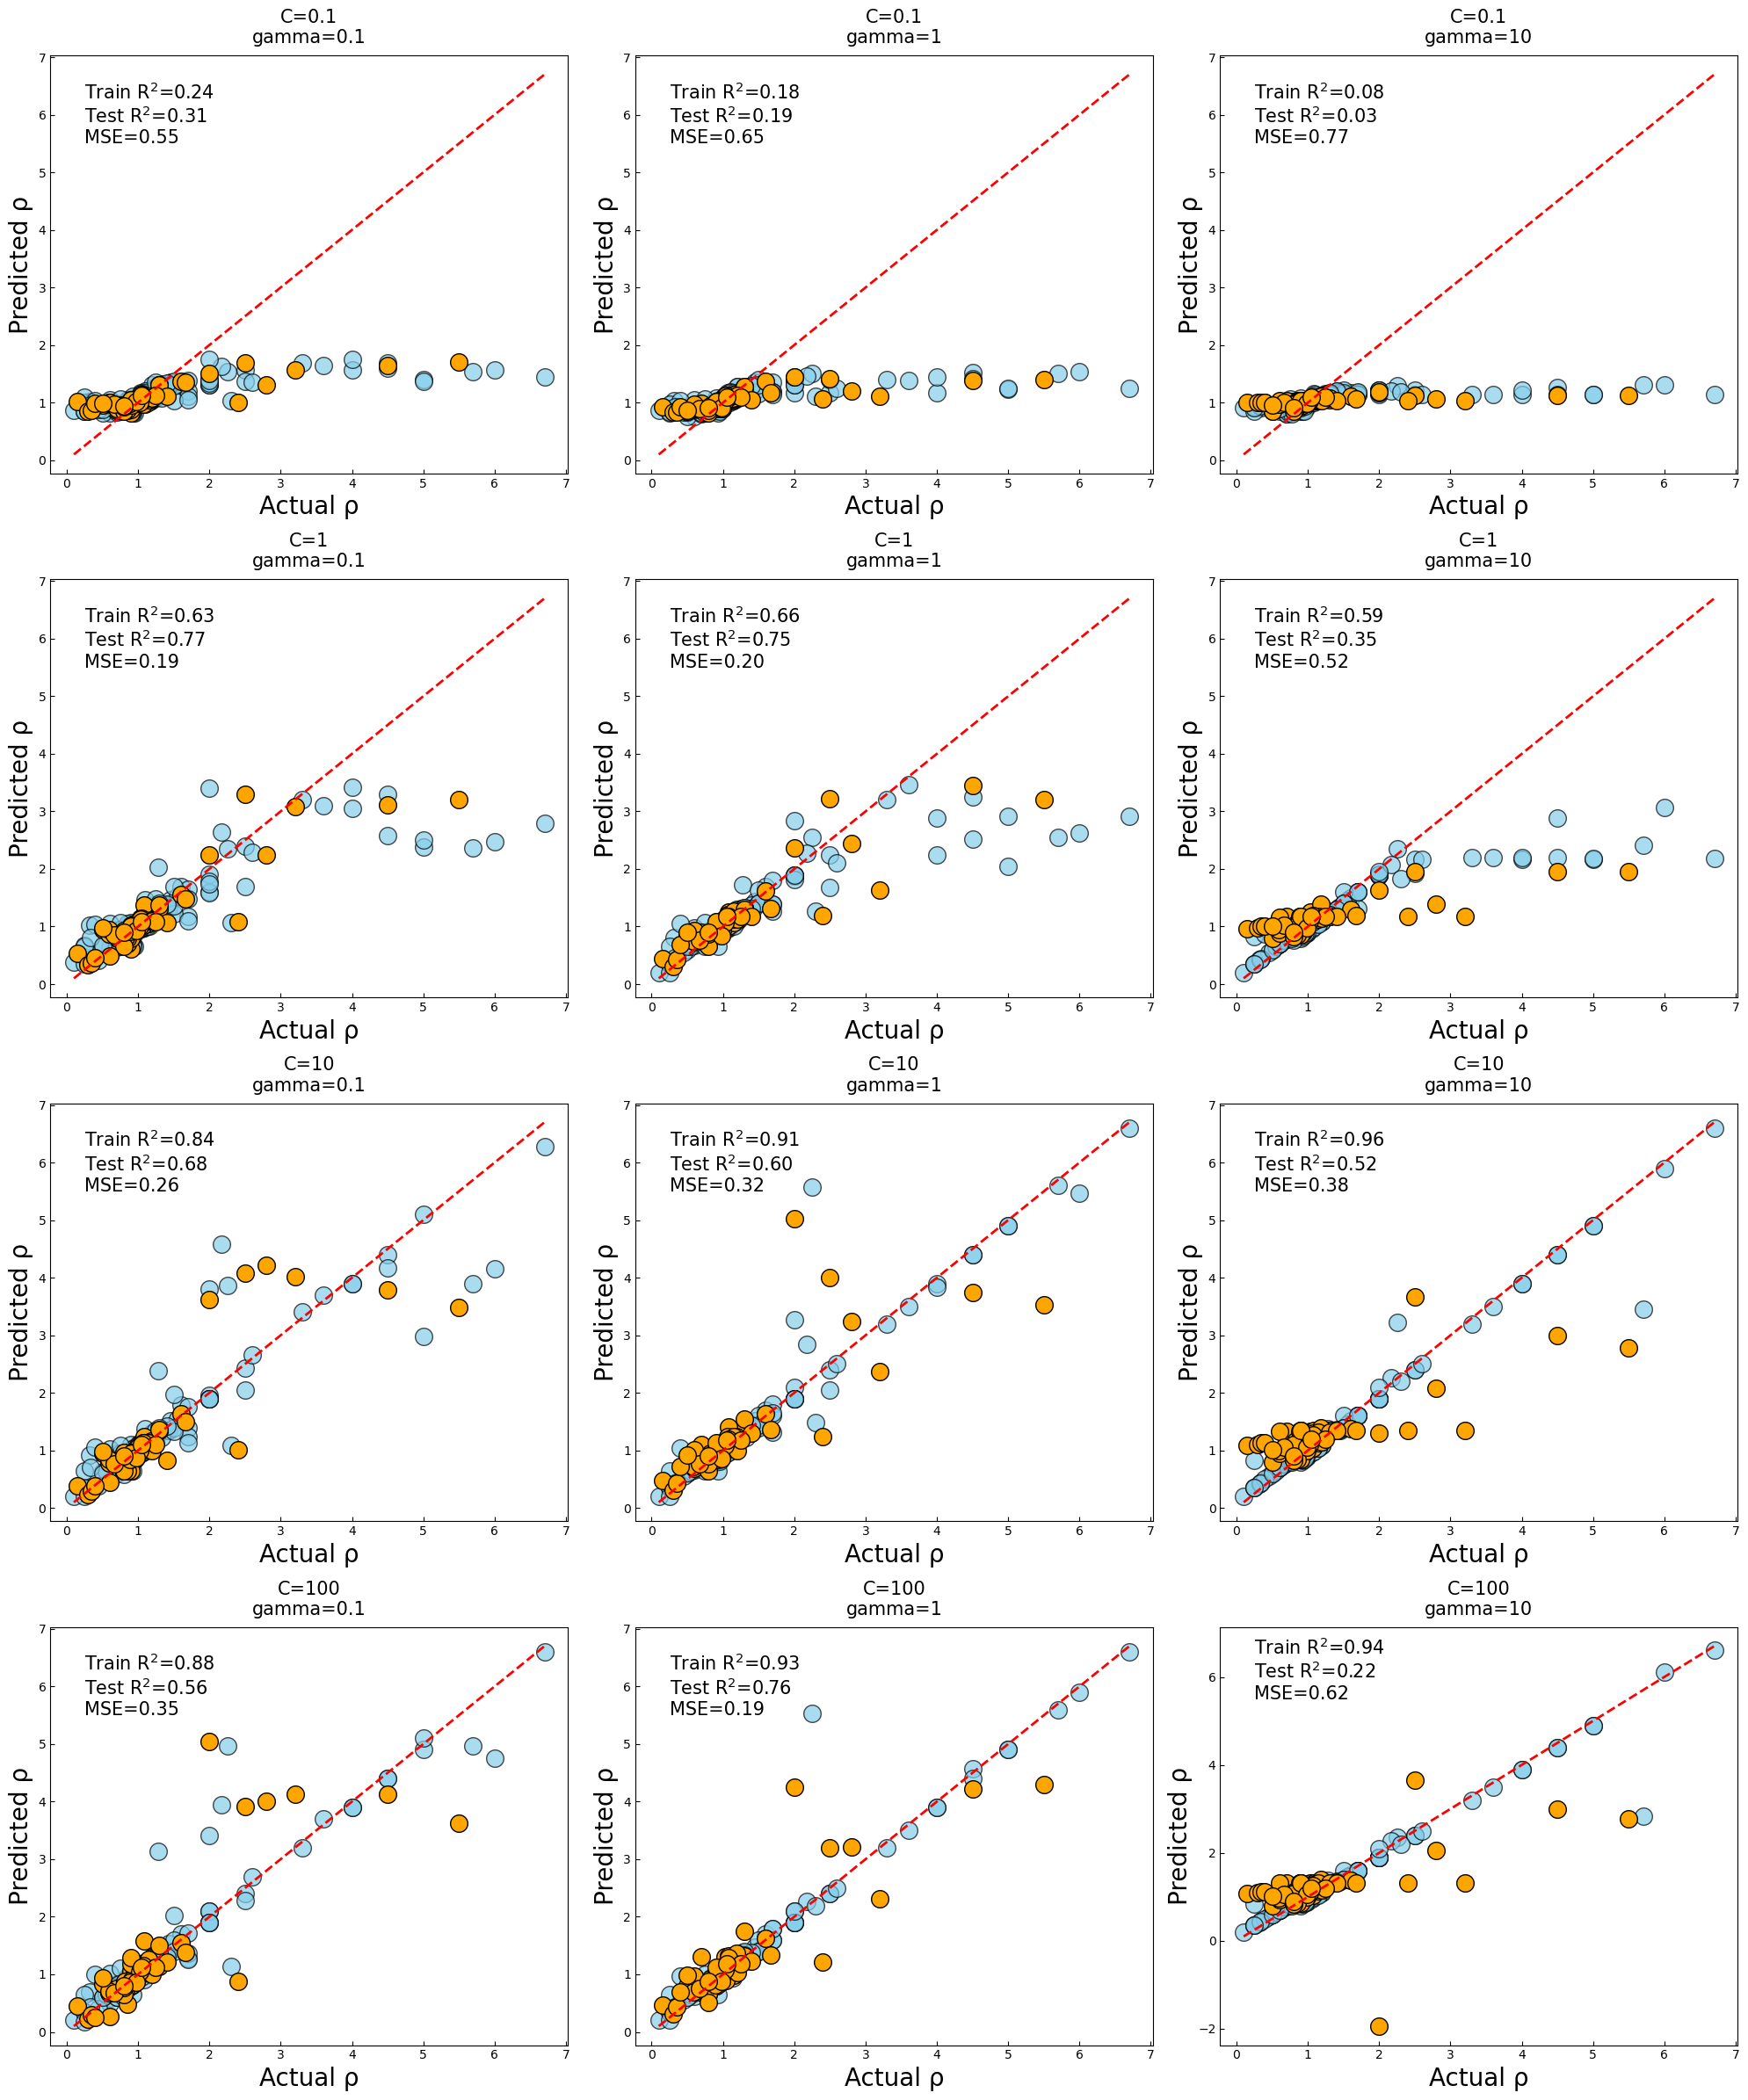

In [9]:
from sklearn.svm import SVR

n = [0.1, 1, 10]
m = [0.1, 1, 10, 100]

fig, subaxes = plt.subplots(len(m), len(n), figsize=(len(m)*5, len(n)*8))

all_train_r2 = []
all_test_r2 = []
all_mse = []

for i, this_m in enumerate(m):
    for j, this_n in enumerate(n):
        svr = SVR(kernel='rbf', C=this_m, gamma=this_n)
        svr.fit(X_train, y_train)
        y_predict = svr.predict(X_test)
        y_predict_2 = svr.predict(X_train)

        subaxes[i, j].scatter(y_train, y_predict_2, s=200, alpha=0.7, edgecolors='black', c='skyblue')
        subaxes[i, j].scatter(y_test, y_predict, s=200, edgecolors='black', c='orange')
        subaxes[i, j].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        subaxes[i, j].set_title(f'C={this_m}\ngamma={this_n}', pad=10, fontsize=15)
        subaxes[i, j].set_xlabel('Actual ρ', size=20)
        subaxes[i, j].set_ylabel('Predicted ρ', size=20)
        
        train_sc = svr.score(X_train, y_train)
        test_sc = svr.score(X_test, y_test)
        mse = mean_squared_error(y_test, y_predict)
        all_train_r2.append(train_sc)
        all_test_r2.append(test_sc)
        all_mse.append(mse)
        
        subaxes[i, j].text(0.25, 5.5, f'Train R$^{2}$={train_sc:.2f}\nTest R$^{2}$={test_sc:.2f}\nMSE={mse:.2f}',
                             fontsize=15)
        subaxes[i, j].tick_params(which='both', direction='in', labelsize=10)

print(all_train_r2)
print(all_test_r2)
print(all_mse)

plt.tight_layout()
plt.savefig('SVR prediction matrix.jpg', format='jpeg', dpi=600)
plt.show()

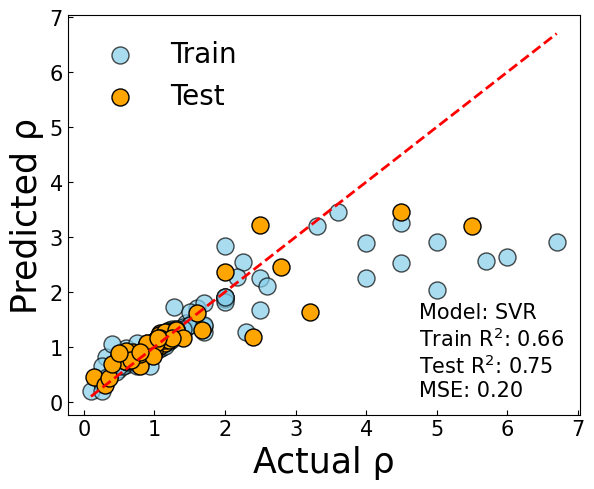

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

svr_best = SVR(kernel='rbf', C=1, gamma=1)
svr_best.fit(X_train, y_train)

y_predict = svr_best.predict(X_test)
y_predict2 = svr_best.predict(X_train)

train_score = svr_best.score(X_train, y_train)
test_score = svr_best.score(X_test, y_test)
mse = mean_squared_error(y_test, y_predict)

fig1 = plt.figure(figsize=(6,5))
plt.scatter(y_train, y_predict2, s=150, c='skyblue', alpha=0.7, label='Train', edgecolors='black')
plt.scatter(y_test, y_predict, s=150, c='orange', label='Test', edgecolors='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(4.75, 0.1, f'Model: SVR\nTrain R$^{2}$: {train_score:.2f}\nTest R$^{2}$: {test_score:.2f}\nMSE: {mse:.2f}', fontsize=15)
plt.legend(loc='best', fontsize=20, frameon=False)
plt.tick_params(which='both', direction='in', labelsize=15)
plt.tight_layout()
plt.savefig('SVR Actual vs. Predicted.jpg', format='jpeg', dpi=600)
plt.show()

Using 244 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/61 [00:00<?, ?it/s]

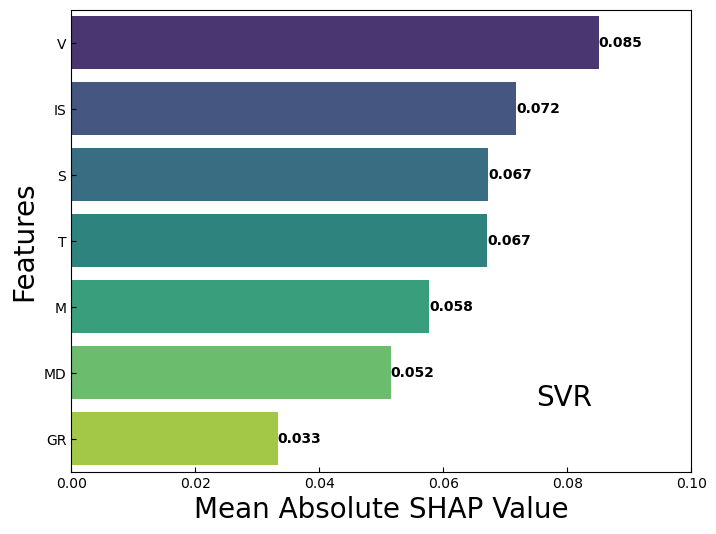

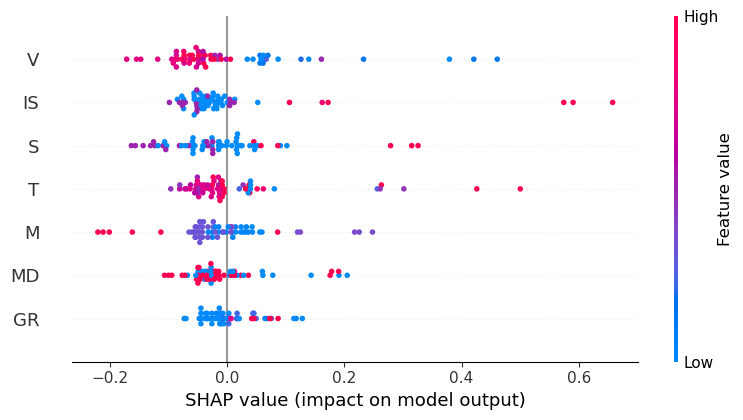

In [13]:
# use SHAP to explain and visualize the feature importance
import shap
shap.initjs()
# Creating the KernelExplainer
svr_explainer = shap.KernelExplainer(svr_best.predict, X_train)
svr_shap_values = svr_explainer.shap_values(X_test)
# Generating the bar plot with mean SHAP values and feature names
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(svr_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
# Adding the values on the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold')

plt.xlim(0,0.1)
plt.xlabel('Mean Absolute SHAP Value', size=20)
plt.ylabel('Features', size=20)
plt.tick_params(which='both', direction='in', labelsize=10)
plt.text(0.075, len(importance_df) - 1.5, 'SVR', fontsize=20)
plt.savefig('SVR SHAP.jpg', format='jpeg', dpi=600)
plt.show()
# Generating the summary plot showing the distribution of SHAP values for each feature
shap.summary_plot(svr_shap_values, X_test, feature_names=X.columns)